### RNN with Attention (Possible solution)

In [15]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)




In [2]:
# Step 1: Prepare the Data
# Load the dataset
df = pd.read_csv('T1.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Convert Date/Time to proper datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
print(f"Date range: {df['Date/Time'].min()} to {df['Date/Time'].max()}")

# Check for missing values and handle them
missing_values = df.isnull().sum()
print(f"\nMissing values:\n{missing_values}")

# Basic exploratory analysis
print(df.describe())


Dataset shape: (50530, 5)
Columns: ['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
Date range: 2018-01-01 00:00:00 to 2018-12-31 23:50:00

Missing values:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64
                           Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684332          7.557952   
min              2018-01-01 00:00:00            -2.471405          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00    

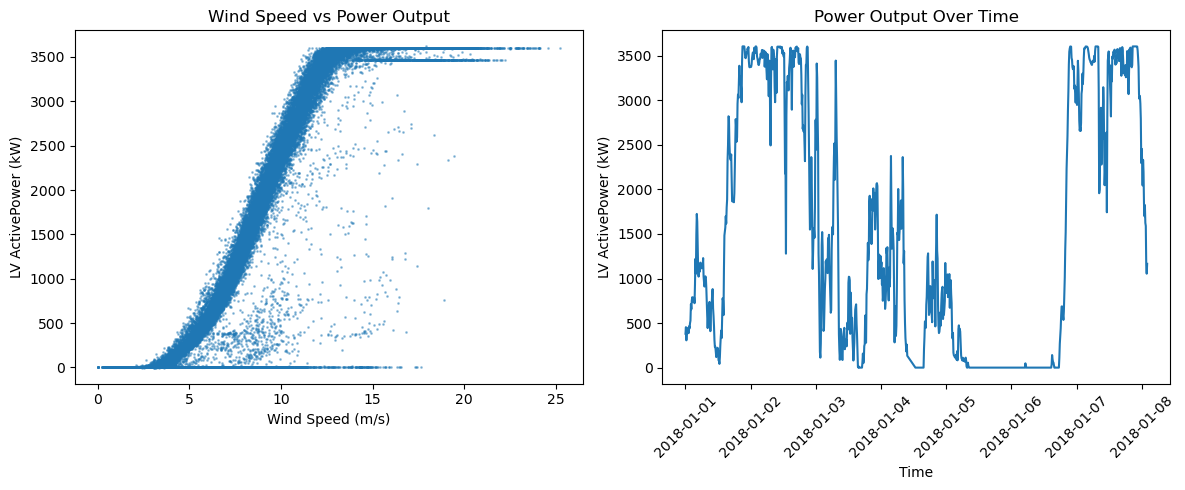

In [3]:
# Visualize relationships

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], alpha=0.4, s=1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.title('Wind Speed vs Power Output')

plt.subplot(1, 2, 2)
plt.plot(df['Date/Time'][:1000], df['LV ActivePower (kW)'][:1000])
plt.xlabel('Time')
plt.ylabel('LV ActivePower (kW)')
plt.title('Power Output Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [4]:
# Select the features for prediction
# LV ActivePower (target)
features_columns = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

data = df[features_columns].values

print(data.shape)
print(features_columns)

# Normalize data using MinMaxScaler
# scales features to [0,1]range for LSTM

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

(50530, 4)
['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']


In [5]:
# Step 2: Create sequences
def create_sequences(data, seq_length):
    """
    Create Sequences for RNN training

    Arguments:
        data: Scaled Dataset
        seq_length: Number of time steps (24 for 24 hours)

    Returns:
        X: Input sequences (samples, time_steps, features)
        y: Target values (samples, 1) - power output only
    """
    X, y = [], []
    
    for i in range(seq_length, len(data)):
        # Input: sequence of all features
        X.append(data[i-seq_length:i])
        # Target: next power output (assumed to be at index 0)
        y.append(data[i, 0])  # LV ActivePower is at index 0

    return np.array(X), np.array(y)

# Define sequence length - 24 hours for daily patterns, daily cycles
seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

print(X.shape)
print(y.shape)



(50506, 24, 4)
(50506,)


In [6]:
# Step 3: Split the data
# Use 80/20 split

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing set - X: {X_test.shape}, y: {y_test.shape}")

Training set - X: (40404, 24, 4), y: (40404,)
Testing set - X: (10102, 24, 4), y: (10102,)


In [7]:
# Step 4: Define a Custom Attention Layer

class AttentionLayer(Layer):
    """
    Custom Attention Layer for focusing on relevant time steps.
    
    The attention mechanism works by:
    1. Computing alignment scores for each time step
    2. Converting scores to attention weights (here softmax)
    3. Creating a weighted context vector
    """
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # Create trainable weight matrix for attention computation
        # maps LSTM hidden size to 1 for scoring each time step
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),  # (hidden_size, 1)
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        
        # Step 1: Compute alignment scores
        # Score each time step based on its relevance
        scores = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1))
        # scores shape: (batch_size, time_steps, 1)
        
        # Step 2: Compute attention weights using softmax
        # This ensures weights sum to 1 and represent importance distribution
        attention_weights = tf.nn.softmax(scores, axis=1)
        # attention_weights shape: (batch_size, time_steps, 1)
        
        # Step 3: Compute context vector as weighted sum
        # Multiply each time step by its attention weight and sum
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        # context_vector shape: (batch_size, features)
        
        return context_vector, attention_weights
    
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[2]), (input_shape[0], input_shape[1], 1)]



In [8]:
# Step 5: Build the RNN Model with Attention
# Use Functional API for more complex architecture
# allows multiple outputs (predictions + attention weights)
inputs = Input(shape=(seq_length, X_train.shape[2]))

# LSTM layers with return_sequences=True
# return_sequences=True Attention needs all time steps, not just the last one
lstm1 = LSTM(50, return_sequences=True)(inputs)
dropout1 = Dropout(0.2)(lstm1)

lstm2 = LSTM(50, return_sequences=True)(dropout1)
dropout2 = Dropout(0.2)(lstm2)

# Apply attention mechanism
# here the model learns to focus on important time steps
context_vector, attention_weights = AttentionLayer()(dropout2)

# Dense layers for final prediction
# Why 25 units? Intermediate layer to process the attended context
dense1 = Dense(25, activation='relu')(context_vector)
outputs = Dense(1)(dense1)  # Single output for power prediction

# Create model with two outputs: predictions and attention weights
model = Model(inputs=inputs, outputs=[outputs, attention_weights])

print("Model architecture:")
model.summary()



Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 50), (None,    │            50 │
│ (AttentionLayer)                │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,551 (127.15 KB)

 Trainable params: 32,551 (127.15 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 6: Compile and Train the Model
# Compile model
# Adam works well with attention mechanisms and adaptive learning rates
# MSE Standard for regression, directly optimizes prediction accuracy

model.compile(
    optimizer='adam',
    loss=['mse', None],  # MSE for predictions, None for attention weights
    loss_weights=[1.0, 0.0],  # Only optimize the first output
    metrics={'dense_1': ['mae']}  # Metrics only for prediction output
)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Slightly more patient due to attention complexity
    restore_best_weights=True,
    verbose=1
)

# For multiple outputs, we need to provide targets for both outputs
# But we are optimizing only the first one (predictions)
# we need to create dummy targets for attention weights (not used in optimization due to loss_weights)
dummy_attention_targets = np.zeros((len(y_train), seq_length, 1))
dummy_attention_val = np.zeros((int(len(y_train) * 0.2), seq_length, 1))

# Prepare training data for multiple outputs
y_train_multi = [y_train, dummy_attention_targets]

history = model.fit(
    X_train, y_train_multi,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - dense_1_mae: 0.1140 - loss: 0.0298 - val_dense_1_mae: 0.0601 - val_loss: 0.0075
Epoch 2/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - dense_1_mae: 0.0662 - loss: 0.0109 - val_dense_1_mae: 0.0469 - val_loss: 0.0050
Epoch 3/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - dense_1_mae: 0.0555 - loss: 0.0077 - val_dense_1_mae: 0.0434 - val_loss: 0.0044
Epoch 4/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - dense_1_mae: 0.0509 - loss: 0.0068 - val_dense_1_mae: 0.0414 - val_loss: 0.0043
Epoch 5/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - dense_1_mae: 0.0492 - loss: 0.0064 - val_dense_1_mae: 0.0450 - val_loss: 0.0045
Epoch 6/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - dense_1_mae: 0.0481 - loss: 0.0063 - val_dense_1_mae: 0.0467 - val_loss: 0.0048
Epoch 7/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - dense_1_mae: 0.0479 - loss: 0.0062 - val_dense_1_mae: 0.0479 - val_loss: 0.0049
Epoch 8/100
1011/1011 ━━━━━━━━━━━━━━━━━━━

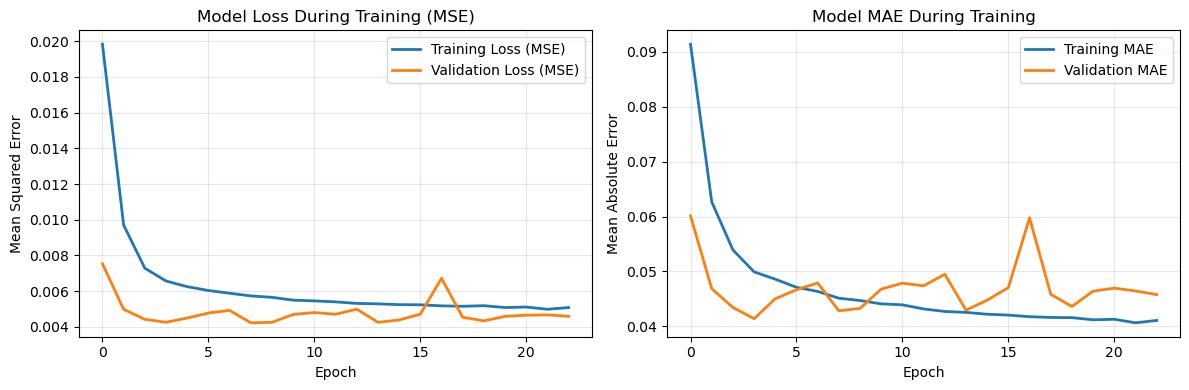

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linewidth=2)
plt.title('Model Loss During Training (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Check if MAE metrics exist in history, otherwise show loss in different scale
if 'dense_1_mae' in history.history:
    plt.plot(history.history['dense_1_mae'], label='Training MAE', linewidth=2)
    plt.plot(history.history['val_dense_1_mae'], label='Validation MAE', linewidth=2)
    plt.title('Model MAE During Training')
    plt.ylabel('Mean Absolute Error')
elif 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
    plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    plt.title('Model MAE During Training')
    plt.ylabel('Mean Absolute Error')
else:
    # Fallback: show loss on different scale for better visualization
    plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', linewidth=2)
    plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE', linewidth=2)
    plt.title('Model RMSE During Training')
    plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Step 7: Evaluate and visualize

# Generate predictions and attention weights
predictions, attention_weights_test = model.predict(X_test)
y_pred = predictions.flatten()

print(f"Predictions shape: {y_pred.shape}")
print(f"Attention weights shape: {attention_weights_test.shape}")

# Inverse transform to original scale
y_test_inv_placeholder = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv_placeholder = np.zeros((len(y_pred), scaled_data.shape[1]))

y_test_inv_placeholder[:, 0] = y_test
y_pred_inv_placeholder[:, 0] = y_pred

y_test_inv = scaler.inverse_transform(y_test_inv_placeholder)[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_inv_placeholder)[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\nModel Performance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f} kW")
print(f"R² Score: {r2:.4f}")

mean_actual = np.mean(y_test_inv)
percentage_error = (rmse / mean_actual) * 100
print(f"RMSE as % of mean power: {percentage_error:.2f}%")


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions shape: (10102,)
Attention weights shape: (10102, 24, 1)

Model Performance Metrics:
MSE: 55469.05
RMSE: 235.52 kW
R² Score: 0.9692
RMSE as % of mean power: 16.06%


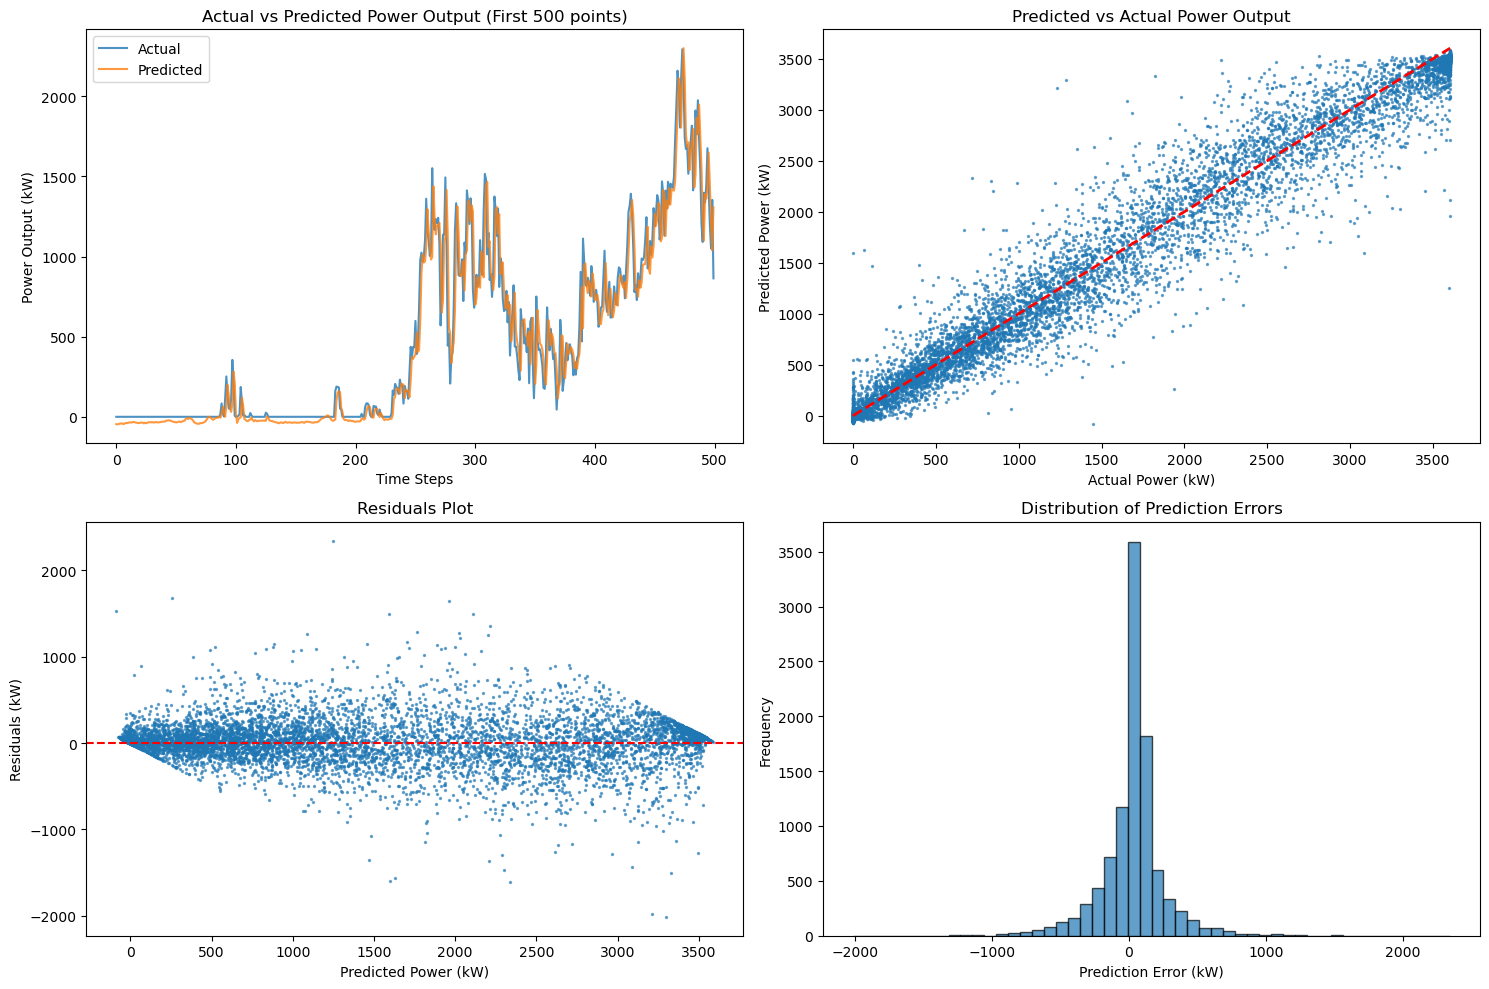

In [23]:
# Main results visualization
plt.figure(figsize=(15, 10))

# Time series comparison
plt.subplot(2, 2, 1)
n_plot = min(500, len(y_test_inv))
plt.plot(y_test_inv[:n_plot], label='Actual', alpha=0.8, linewidth=1.5)
plt.plot(y_pred_inv[:n_plot], label='Predicted', alpha=0.8, linewidth=1.5)
plt.title(f'Actual vs Predicted Power Output (First {n_plot} points)')
plt.xlabel('Time Steps')
plt.ylabel('Power Output (kW)')
plt.legend()

# Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, s=2)
plt.plot([y_test_inv.min(), y_test_inv.max()], 
         [y_test_inv.min(), y_test_inv.max()], 'r--', lw=2)
plt.xlabel('Actual Power (kW)')
plt.ylabel('Predicted Power (kW)')
plt.title('Predicted vs Actual Power Output')

# Residuals
plt.subplot(2, 2, 3)
residuals = y_test_inv - y_pred_inv
plt.scatter(y_pred_inv, residuals, alpha=0.6, s=2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Power (kW)')
plt.ylabel('Residuals (kW)')
plt.title('Residuals Plot')

# Error distribution
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error (kW)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

plt.tight_layout()
plt.show()

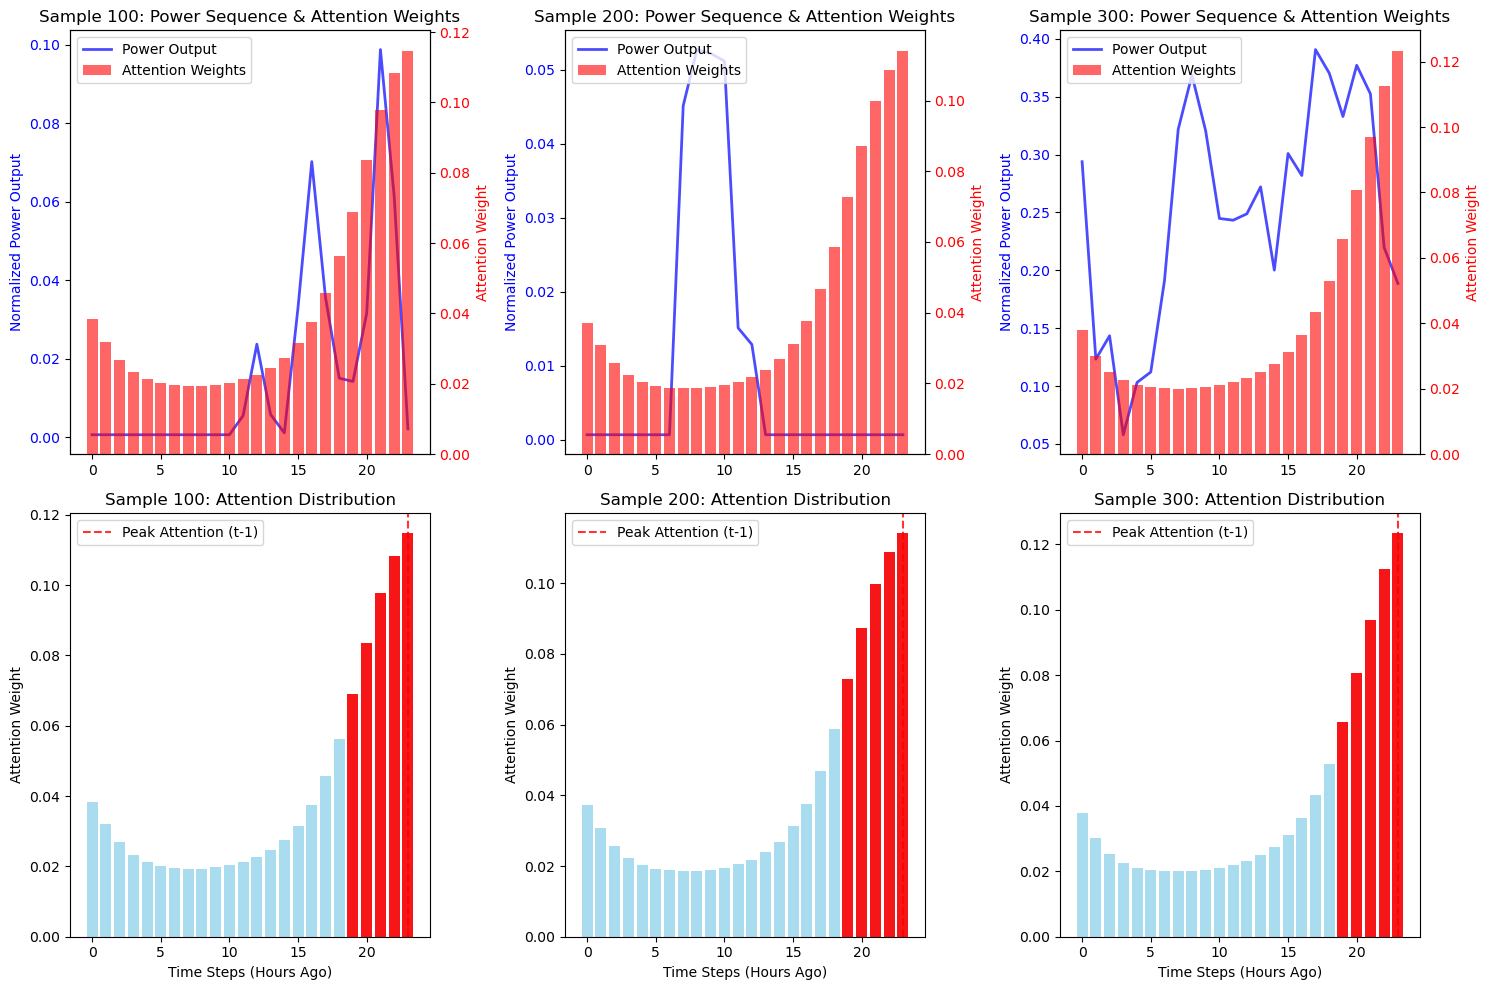

In [25]:
# Attention weights analysis
# Select a few samples to visualize attention
sample_indices = [100, 200, 300]

plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+1)
    
    # Plot the input sequence features
    sample_input = X_test[idx]  # Shape: (seq_length, n_features)
    sample_attention = attention_weights_test[idx].flatten()  # Shape: (seq_length,)
    
    # Plot power output (target feature) with attention weights
    power_sequence = sample_input[:, 0]  # LV ActivePower feature
    
    # Create dual y-axis plot
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot power sequence
    line1 = ax1.plot(range(seq_length), power_sequence, 'b-', alpha=0.7, 
                     label='Power Output', linewidth=2)
    ax1.set_ylabel('Normalized Power Output', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot attention weights as bars
    bars = ax2.bar(range(seq_length), sample_attention, alpha=0.6, 
                   color='red', label='Attention Weights')
    ax2.set_ylabel('Attention Weight', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title(f'Sample {idx}: Power Sequence & Attention Weights')
    plt.xlabel('Time Steps (Hours Ago)')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Additional attention analysis plots
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+4)
    
    sample_attention = attention_weights_test[idx].flatten()
    
    # Find top attention time steps
    top_indices = np.argsort(sample_attention)[-5:]  # Top 5 most attended steps
    
    plt.bar(range(seq_length), sample_attention, alpha=0.7, color='skyblue')
    plt.bar(top_indices, sample_attention[top_indices], alpha=0.9, color='red')
    
    plt.title(f'Sample {idx}: Attention Distribution')
    plt.xlabel('Time Steps (Hours Ago)')
    plt.ylabel('Attention Weight')
    
    # Highlight most important time steps
    max_attention_idx = np.argmax(sample_attention)
    plt.axvline(x=max_attention_idx, color='red', linestyle='--', alpha=0.8,
                label=f'Peak Attention (t-{seq_length-max_attention_idx})')
    plt.legend()

plt.tight_layout()
plt.show()





In [26]:
# Attention statistics
print("\nAttention Analysis:")
mean_attention = np.mean(attention_weights_test, axis=0).flatten()
std_attention = np.std(attention_weights_test, axis=0).flatten()

print(f"Average attention across all samples:")
print(f"Most attended time step: t-{seq_length - np.argmax(mean_attention)} "
      f"(weight: {np.max(mean_attention):.4f})")
print(f"Least attended time step: t-{seq_length - np.argmin(mean_attention)} "
      f"(weight: {np.min(mean_attention):.4f})")


Attention Analysis:
Average attention across all samples:
Most attended time step: t-1 (weight: 0.1243)
Least attended time step: t-18 (weight: 0.0202)


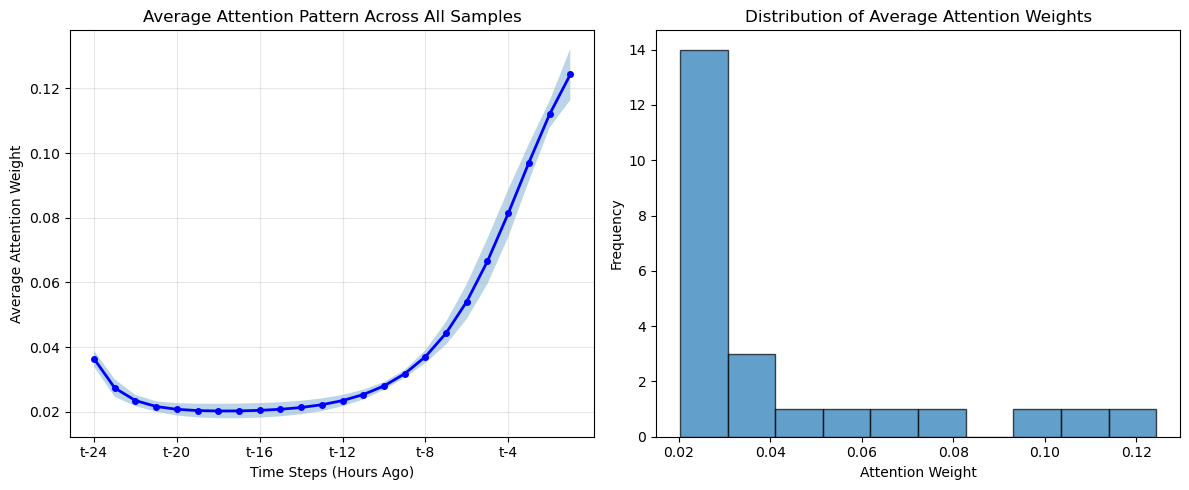


Model Training and Analysis Complete
Final Model Performance: R² = 0.9692, RMSE = 235.52 kW


In [27]:

# Plot average attention pattern
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
time_labels = [f't-{seq_length-i}' for i in range(seq_length)]
plt.plot(range(seq_length), mean_attention, 'b-', linewidth=2, marker='o', markersize=4)
plt.fill_between(range(seq_length), 
                 mean_attention - std_attention, 
                 mean_attention + std_attention, 
                 alpha=0.3)
plt.title('Average Attention Pattern Across All Samples')
plt.xlabel('Time Steps (Hours Ago)')
plt.ylabel('Average Attention Weight')
plt.xticks(range(0, seq_length, 4), [time_labels[i] for i in range(0, seq_length, 4)])
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(mean_attention, bins=10, alpha=0.7, edgecolor='black')
plt.title('Distribution of Average Attention Weights')
plt.xlabel('Attention Weight')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nModel Training and Analysis Complete")
print(f"Final Model Performance: R² = {r2:.4f}, RMSE = {rmse:.2f} kW")
